# Realistic lightcurves of ellipsoids

This notebook demonstrates how to generate lightcurves within `sorcha`,
under the assumption that the Solar System Objects (SSOs) are simple tri-axial ellipsoids, defined 
by 
$ a \ge b \ge c$,
in simple short-axis rotation mode.

In [1]:
import numpy as np
import pandas as pd

import rocks
import requests

import astropy.units as u
from astropy.coordinates import SkyCoord

from sorcha.modules.PPCalculateApparentMagnitudeInFilter import (
    PPCalculateApparentMagnitudeInFilter,
)

import matplotlib.pyplot as plt

# Constant
au = 1.495978707e8  # AU in km

/home/bcarry/anaconda3/envs/sorcha/lib/python3.11/site-packages/assist/__init__.py:44: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


## Lightweight ephemeris function

We will need to compute ephemerides, so let's query the [Miriade](https://ssp.imcce.fr/webservices/miriade/) Virtual Observatory Web service.

In [2]:
def ephemcc(ident, ep, nbd=None, step=None, observer="500", rplane="1", tcoor=5):
    """Gets asteroid ephemerides from IMCCE Miriade for a suite of JD for a single SSO
    Original function by M. Mahlke

    :ident: int, float, str - asteroid identifier
    :ep: float, str, list - Epoch of computation
    :observer: str - IAU Obs code - default to geocenter: https://minorplanetcenter.net//iau/lists/ObsCodesF.html
    :returns: pd.DataFrame - Input dataframe with ephemerides columns appended
              False - If query failed somehow

    """

    # ------
    # Miriade URL
    url = "https://ssp.imcce.fr/webservices/miriade/api/ephemcc.php"

    # Query parameters
    params = {
        "-name": f"{ident}",
        "-mime": "json",
        "-rplane": rplane,
        "-tcoor": tcoor,
        "-output": "--jd",
        "-observer": observer,
        "-tscale": "UTC",
    }

    # Single epoch of computation
    if type(ep) != list:
        # Set parameters
        params["-ep"] = ep
        if nbd != None:
            params["-nbd"] = nbd
        if step != None:
            params["-step"] = step

        # Execute query
        try:
            r = requests.post(url, params=params, timeout=80)
        except requests.exceptions.ReadTimeout:
            return False

    # Multiple epochs of computation
    else:
        # Epochs of computation
        files = {"epochs": ("epochs", "\n".join(["%.6f" % epoch for epoch in ep]))}

        # Execute query
        try:
            r = requests.post(url, params=params, files=files, timeout=50)
        except requests.exceptions.ReadTimeout:
            return False

    j = r.json()

    # Read JSON response
    try:
        ephem = pd.DataFrame.from_dict(j["data"])
    except KeyError:
        return False

    return ephem

## Definition of simulation

We first define the epochs of the simulation: starting date (expressed in JD), the number of epochs to simulate, and time step between each (in days).

In [3]:
# Choice of time frame
jd0 = 2461041.5 # Start date: here set to 2026-01-01
nbd = 1500 # Number of epochs
step = 0.3 # Time step between epochs (days)


We then define the target. It can be an asteroid name/designation or number.
The absolute magnitude and spin properties (coordinates and period) are then retrieved from [SsODNet](https://ssp.imcce.fr/webservices/ssodnet/) (see [Berthier et al., 2023](https://ui.adsabs.harvard.edu/abs/2023A%26A...671A.151B/abstract)). Alternatively, you can define all parameters by hand:

- ``H`` the absolute magnitude
- ``ra0`` the right ascension of the spin coordinates (equatorial frame, in degrees) 
- ``dec0`` the declination of the spin coordinates (equatorial frame, in degrees) 
- ``period`` the sidereal rotation period (in hour) 
- ``G1`` and ``G2`` the phase curve coefficients
- ``a_b`` the ratio of equatorial diameters (_a_ and _b_)
- ``a_c`` the ratio between the longest (equatorial) diameter (_a_) and the polar diameter (_c_)

In [4]:
# Target
sso = 22

# Retrieve the target properties from SsODNet
sc = rocks.Rock(sso)
H = sc.H.value
ra0 = sc.spin.RA0.value
dec0 = sc.spin.DEC0.value
period = sc.spin.period.value[0] / 24.0

# Arbitrary phase function and shape
G1 = 0.62
G2 = 0.14
a_b = 1.5
a_c = 2.0

In [5]:
# Generate ephemerides
eph = ephemcc(sso, ep=jd0, nbd=nbd, step=step, tcoor=5, observer='X05')

In [6]:
# Build the observations dataframe
observations_df = pd.DataFrame(
    {
        "fieldMJD_TAI": eph.Date.values,
        "H_filter": H * np.ones(nbd),
        "G1": G1 * np.ones(nbd),
        "G2": G2 * np.ones(nbd),
        "RA_deg": eph.RA.values,
        "Dec_deg": eph.DEC.values,
        "Period": period * np.ones(nbd),
        "Time0": jd0 * np.ones(nbd), 
        "phi0": np.radians(0) * np.ones(nbd),
        "RA0": np.radians(ra0) * np.ones(nbd),
        "Dec0": np.radians(dec0) * np.ones(nbd),
        "Period": period * np.ones(nbd),
        "a/b": a_b * np.ones(nbd),
        "a/c": a_c * np.ones(nbd),
        "Range_LTC_km": eph.Dobs.values * au,
        "Obj_Sun_LTC_km": eph.Dhelio.values * au,
        "phase_deg": eph.Phase.values,
    }
)

observations_df

,fieldMJD_TAI,H_filter,G1,G2,RA_deg,Dec_deg,Period,Time0,phi0,RA0,Dec0,a/b,a/c,Range_LTC_km,Obj_Sun_LTC_km,phase_deg
0,2461041.5,6.79,0.62,0.14,359.334334,-11.523769,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.177865e+08,4.049300e+08,20.522908
1,2461041.8,6.79,0.62,0.14,359.407445,-11.465113,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.183388e+08,4.048958e+08,20.502883
2,2461042.1,6.79,0.62,0.14,359.482166,-11.406700,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.188799e+08,4.048617e+08,20.481478
3,2461042.4,6.79,0.62,0.14,359.555298,-11.348389,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.194149e+08,4.048277e+08,20.461570
4,2461042.7,6.79,0.62,0.14,359.628519,-11.289645,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,4.199635e+08,4.047937e+08,20.441432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2461490.0,6.79,0.62,0.14,100.442283,35.559274,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.696081e+08,4.089152e+08,21.330520
1496,2461490.3,6.79,0.62,0.14,100.514005,35.545997,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.702196e+08,4.089530e+08,21.336566
1497,2461490.6,6.79,0.62,0.14,100.583783,35.532027,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.708370e+08,4.089908e+08,21.344123
1498,2461490.9,6.79,0.62,0.14,100.656047,35.517137,0.172842,2461041.5,0.0,3.405137,-0.049463,1.5,2.0,3.714625e+08,4.090287e+08,21.349582


## SORCHA simulation

We first simply compute the apparent magnitude, using the
$H G_1 G_2$ formalism, as a baseline.

In [7]:
observations_df = PPCalculateApparentMagnitudeInFilter(observations_df.copy(), "HG1G2", "r", "HG1G2_mag")

We then load the lightcurve methods of ``SORCHA`` add-ons:

In [8]:
from sorcha.lightcurves.lightcurve_registration import LC_METHODS, update_lc_subclasses
update_lc_subclasses()
print('Lightcurve methods: ' + ', '.join(LC_METHODS))

Lightcurve methods: identity, sinusoidal, ellipsoidal, ellipsoidalwithterminator


We can now compute the apparent magnitude **with** the lightcurve effect (using the
$H G_1 G_2$ formalism for consistency).

In [9]:
observations_df = PPCalculateApparentMagnitudeInFilter(
    observations_df.copy(), "HG1G2", "r", "LC_HG1G2_mag", "ellipsoidal"
)

## Graphics illustrating the lightcurve effect

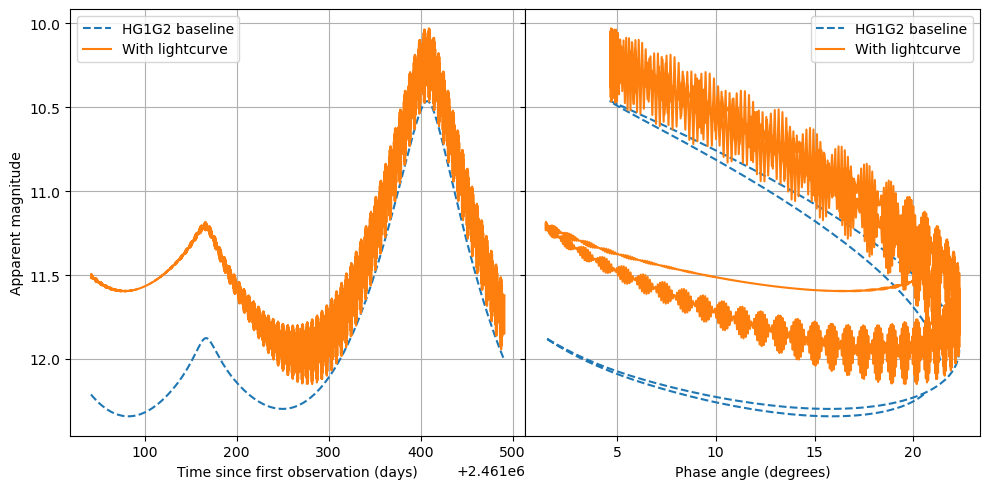

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True, gridspec_kw={"wspace": 0})

# --------------------------------------------------------------------------------
# Apparent magnitude vs time
ax[0].plot(
    observations_df["fieldMJD_TAI"],
    observations_df["HG1G2_mag"],
    linestyle="--",
    color="C0",
    label="HG1G2 baseline",
)
ax[0].plot(
    observations_df["fieldMJD_TAI"],
    observations_df["LC_HG1G2_mag"],
    linestyle="-",
    color="C1",
    label="With lightcurve",
)

# --------------------------------------------------------------------------------
# Apparent magnitude vs phase
ax[1].plot(
    observations_df["phase_deg"],
    observations_df["HG1G2_mag"],
    linestyle="--",
    color="C0",
    label="HG1G2 baseline",
)
ax[1].plot(
    observations_df["phase_deg"],
    observations_df["LC_HG1G2_mag"],
    linestyle="-",
    color="C1",
    label="With lightcurve",
)

# --------------------------------------------------------------------------------
# Axes
for a in ax:
    a.legend()
    a.grid()
ax[0].set_xlabel("Time since first observation (days)")
ax[1].set_xlabel("Phase angle (degrees)")
ax[0].set_ylabel("Apparent magnitude")
ax[0].invert_yaxis()

fig.tight_layout()
fig.savefig("ellipsoidal_lightcurve_example.png", dpi=300)